In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import spacy

import torch
import torchtext
from torchtext.vocab import vocab

import os
from os.path import join
from collections import Counter, OrderedDict
from tqdm import tqdm
import pickle as pkl
 
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_lg')

In [2]:
raw_train_path = "../raw_data/fulltrain.csv"

with open(raw_train_path) as f:
    df_train = pd.read_csv(f, names=['class', 'text'])
df_train.head()

,class,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [3]:
df_train.drop_duplicates(inplace=True,ignore_index=True)

train_texts = df_train['text'].values
train_labels = df_train['class'].values

In [4]:
# load stopwords
stop_words_path = "../raw_data/stopwords_en.txt"

with open(stop_words_path) as file:
    stop_words = file.read().splitlines()
stop_words = set(stop_words)  # convert to dictionary to speed up searching

### Tokenization & Get frequency dict

In [5]:
def preprocess(docs:list[str]) -> list[list[str]]:
    """clean and tokenize the data"""
    """remove stopwords, oov words and punctuations"""
    
    processed_docs = []
    with tqdm(total=len(docs)) as progress_bar:
        for doc in nlp.pipe(docs):
            tokens = []
            for token in doc:
                if token.text in stop_words or token.is_punct or token.is_oov:
                    continue
                else:
                    tokens.append(token.text.lower())
            processed_docs.append(tokens)
            # update the progress bar
            progress_bar.update(1)
    return processed_docs

tokenized_text = preprocess(train_texts)

  0%|          | 0/48652 [00:00<?, ?it/s]

100%|██████████| 48652/48652 [56:23<00:00, 14.38it/s]  


In [11]:
# save the results

# path = "../processed_data/train_tokenized"
# with open(path, 'wb') as f:
#     pkl.dump(tokenized_text, f)

In [12]:
# calculate token frequency
def text_iterator(texts):
    for text in texts:
        yield text

freq_dict = Counter()
with tqdm(total=len(tokenized_text)) as progress_bar:
    for text in text_iterator(tokenized_text):
        freq_dict.update(text)
        progress_bar.update(1)

  0%|          | 0/48652 [00:00<?, ?it/s]

100%|██████████| 48652/48652 [00:02<00:00, 21276.30it/s]


### Get the vocabulary

First, let's calculate the needed size of the vocabulary

In [13]:
def cal_vocab_size(freq_dict, cover_rate=0.95):
    """calculate the needed vocabulary size"""
    sorted_freq = sorted(freq_dict.values(),reverse=True)
    total_freq = sum(sorted_freq)
    cumulative_freq = 0
    vocab_size = 0
    for freq in sorted_freq:
        vocab_size += 1
        cumulative_freq += freq
        if cumulative_freq >= total_freq * cover_rate:
            break
    print(f'The first {vocab_size} words covers {int(100*cover_rate)}% of the corpus')

cal_vocab_size(freq_dict)

The first 21785 words covers 95% of the corpus


It seems that 25000 could be a good choice.

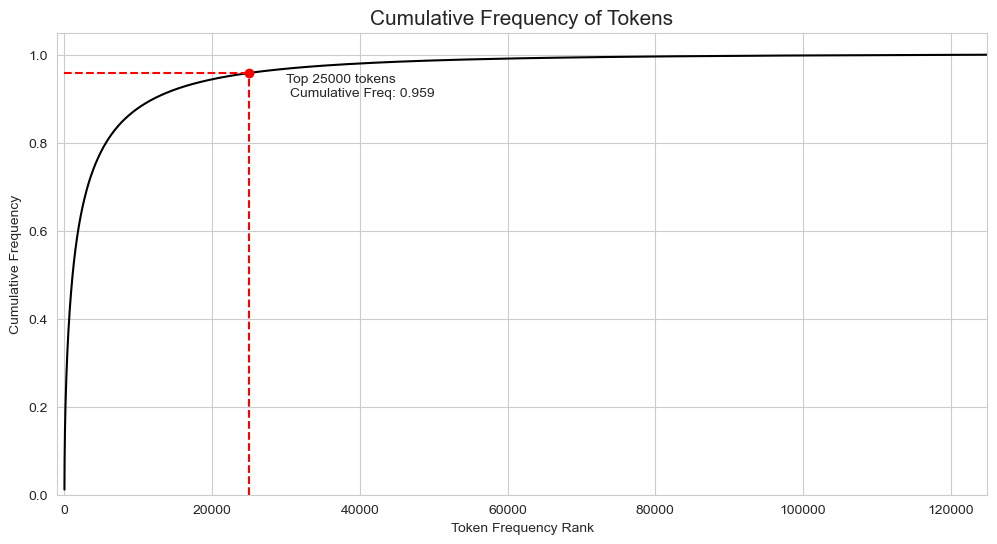

In [14]:
def plot_cum_token_frequency(freq_dict,top_k=25000):
    sorted_freq = sorted(freq_dict.values(),reverse=True)
    cum_freq = np.cumsum(sorted_freq) / np.sum(sorted_freq)
    # plot_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="whitegrid", rc=plot_params)
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6))
    
    plt.plot(cum_freq,c='k')
    plt.scatter(top_k,cum_freq[top_k],c='r',zorder=2)
    plt.vlines(top_k, 0, cum_freq[top_k], colors='r', linestyles='dashed')
    plt.hlines(cum_freq[top_k], 0, top_k, colors='r', linestyles='dashed')

    plt.xlim(-1000,len(freq_dict))
    plt.ylim(0,1.05)
    plt.title('Cumulative Frequency of Tokens',fontsize=15)
    plt.xlabel('Token Frequency Rank')
    plt.ylabel('Cumulative Frequency')

    plt.text(top_k+5000,cum_freq[top_k], f'Top {top_k} tokens\n Cumulative Freq: {cum_freq[top_k]:.3f}',
         verticalalignment='top', horizontalalignment='left')
    
    plt.grid(True)

    # plt.savefig('Cumulative Frequency of Tokens.svg', format='svg')

plot_cum_token_frequency(freq_dict)

Then let's create and save the vocabulary

In [15]:
top_k = 25000
sorted_freq_dict = sorted(freq_dict.items(), key=lambda x:x[1], reverse=True)

sorted_freq_dict = OrderedDict(sorted_freq_dict[:top_k])

# special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

SPECIALS = [PAD_TOKEN, UNK_TOKEN]

vocabulary = vocab(sorted_freq_dict, specials=SPECIALS)
vocabulary.set_default_index(vocabulary[UNK_TOKEN])

In [16]:
# save the vocabulary
file_name = f"../processed_data/remove-stopwords-punct-{top_k}.vocab"

torch.save(vocabulary, file_name)

### Vectorize the dataset

First let's check the distribution of lengths.

In [17]:
text_lens = pd.Series([len(text) for text in tokenized_text])
text_lens.describe()

count    48652.000000
mean       304.073337
std        525.388700
min          0.000000
25%         84.000000
50%        160.000000
75%        404.000000
max      66580.000000
dtype: float64

c:\Users\Tim\anaconda3\envs\py310_gpu\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


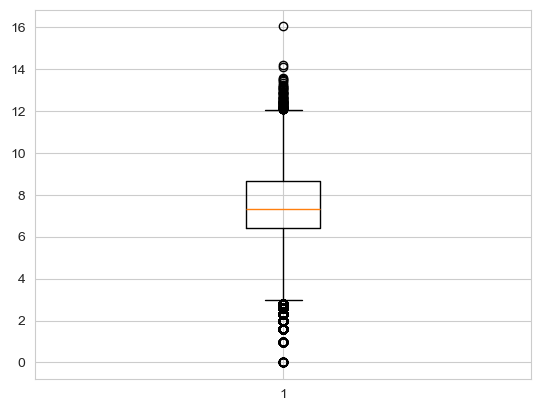

In [20]:
plt.boxplot(np.log2(text_lens))
plt.show()

Apparently outliers exist. Most of the texts' lengths are between 8 and 4096. I chose to remove the texts whose lengths are under 8 and truncate the texts whose lengths are greater than 4096.

In [23]:
def vectorize(docs, labels, vocab, max_len=4096):
    """convert tokens of texts into indices"""
    """remove texts whose lengths < 8"""
    """truncate texts whose lengths > 4096"""
    train_vecs = []
    train_labels = []
    for i,text in enumerate(docs):
        if len(text) > 8:
            if len(text) > max_len:  # truncate the text
                text_vec = text_vec[:max_len]
            text_vec = vocab.lookup_indices(text)
            train_vecs.append(text_vec)
            train_labels.append(labels[i])
    return train_vecs, train_labels

In [24]:
train_vecs, train_labels = vectorize(tokenized_text, train_labels, vocab=vocabulary)

Let's have a check

In [25]:
print(train_vecs[0][:5])
print(vocabulary.lookup_tokens(train_vecs[0][:5]))

[24, 122, 1291, 242, 5516]
['a', 'little', 'decade', 'ago', 'hockey']


In [26]:
# split training and validation sets
X_train,X_val,y_train,y_val = train_test_split(train_vecs,train_labels,test_size=0.3,random_state=2024,stratify=train_labels)

# save the results
train_name = "../processed_data/train.pickle"
val_name = "../processed_data/val.pickle"

with open(train_name, 'wb') as f:
    pkl.dump((X_train,y_train), f)

with open(val_name, 'wb') as f:
    pkl.dump((X_val,y_val), f)

### process test set

In [27]:
raw_test_path = '../raw_data/balancedtest.csv'
with open(raw_test_path) as f:
    df_test = pd.read_csv(f, names=['class', 'text'])

test_texts = df_test['text'].values
test_labels = df_test['class'].values

test_texts_tokenized = preprocess(test_texts)
X_test, y_test = vectorize(test_texts_tokenized, test_labels, vocabulary)

# save the results
test_name = "../processed_data/test.pickle"
with open(test_name, 'wb') as f:
    pkl.dump((X_test,y_test), f)

100%|██████████| 3000/3000 [04:11<00:00, 11.92it/s]
